In [ ]:
# !pip install apyori

In [ ]:
import pandas as pd
import json
import pprint
import dask.dataframe as dd # 中資料集分散運算（類似spark）
from apyori import apriori 
from geopy.distance import geodesic # 算距離
import re
import networkx as nx # 畫關係圖
import matplotlib.pyplot as plt
# from mlxtend.frequent_patterns import apriori, association_rules # 關聯式分析

### 讀原始資料
- review評論數： 6375018 ，約 637.5 萬
- user使用者數： 1764969 ，約 176.5 萬
- location_id景點數： 838

In [2]:
##### 讀檔
# 地點基本資訊(838)
with open("../data/838-地點基本資訊.json", 'r') as file:
    loc_info_json = json.load(file)                      # 讀json檔
loc_info_org = pd.json_normalize(loc_info_json)    # 將json轉pd.DataFrame

# 地點清單(838)
loc_list_org = pd.read_csv("../data/838-地點清單.csv", encoding="utf-8")

# 所有評論原始資料(6,375,018)
gmap_review_org = pd.read_csv("../data/838-所有評論原始資料.csv", encoding="utf-8")

# 所有評論_語系修正_nlp斷詞(6,375,018)
gmap838_nlp_org = pd.read_csv("../data/gmap838_nlp.csv", encoding="utf-8")

##### 存回csv
# df.to_csv("output.csv", index=False, encoding="utf-8")

print('loc_info_org:',len(loc_info_org))
print('loc_list_org:',len(loc_list_org))
print('gmap_review_org:',len(gmap_review_org))
print('gmap838_nlp_org:',len(gmap838_nlp_org))

loc_info_org: 838
loc_list_org: 838
gmap_review_org: 6375018
gmap838_nlp_org: 6375018


/var/folders/sj/mtls40j55rn87dkczphv9vn80000gn/T/ipykernel_11611/1524319038.py:14: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  gmap838_nlp_org = pd.read_csv("../data/gmap838_nlp.csv", encoding="utf-8")


### 評論數統計 & 保留需要欄位


In [3]:
##### 建立 使用者_總評論數
user_total_reviews = gmap_review_org.groupby('user_id').size().reset_index(name='user_reviews_count')
user_total_reviews = user_total_reviews.sort_values(by='user_reviews_count', ascending=False) # 多到少

##### 建立 各景點_總評論數
location_total_reviews = gmap_review_org.groupby('location_id').size().reset_index(name='location_reviews_count')
location_total_reviews = location_total_reviews.sort_values(by='location_reviews_count', ascending=False)


##### 留需要資訊
# 地點基本資訊(838)
loc_info = loc_info_org # 暫無修改

# 地點清單(838)
loc_list = loc_list_org[["gmap_location", "location_id", "gmap_coordinates", "attraction_type"]]

# 所有評論_語系修正_nlp斷詞(6,375,018)
gmap838_nlp = gmap838_nlp_org[['review_id', 'langTag', 'snownlp_scores', 'snownlp_scores_0-100']]

# 所有評論(6,375,018)（語系使用gmap838_nlp檔案作為依據，新增欄位：nlp情緒分數 / user總評論數 / 景點總評論數）
gmap_review_org_2 = gmap_review_org[['review_id', 'gmap_location', 'location_id', 'user_name', 'user_id', 'score', 'date', 'comments', 'translated_comments']] 
gmap_review_org_3 = gmap_review_org_2.merge(gmap838_nlp,on='review_id').merge(user_total_reviews, on='user_id').merge(location_total_reviews, on='location_id')
gmap_review = gmap_review_org_3


print('loc_info:',len(loc_info))
print('loc_list:',len(loc_list))
print('gmap838_nlp:',len(gmap838_nlp))
print('gmap_review:',len(gmap_review))


loc_info: 838
loc_list: 838
gmap838_nlp: 6375018
gmap_review: 6375018


### 前三大語系使用者 

| **語系** | **法一** | **法二** |
|----------|--------------|----------|
| 繁中 | **793,373** | **786,120** |
| 英文 | **73,958** | **66,914** |
| 日文 | **19,493** | **15,408** |
| 韓文 | **20,795** | **20,588** |

##### 法一：
暫不處理使用者用不同語系問題，若曾用過，則認定為該語系使用者，ex:若曾使用過日文、英文，抓各語系使用者時會被重複抓取。

In [4]:
##### 法1:
# 中文使用者id
zh_user = gmap_review[gmap_review['langTag'].isin(['zh-Hant'])]["user_id"].unique()
print(len(zh_user))

# 英文使用者id
en_user = gmap_review[gmap_review['langTag'] == 'en']["user_id"].unique()
print(len(en_user))

# 日文使用者id
ja_user = gmap_review[gmap_review['langTag'] == 'ja']["user_id"].unique()
print(len(ja_user))

# 韓文使用者id
ko_user = gmap_review[gmap_review['langTag'] == 'ko']["user_id"].unique()
print(len(ko_user))



793373
73958
19493
20795


##### 法二：
抓主要使用語言。

In [5]:
##### 法2: 定義每位使用者國籍

##### 使用者語系（911,791位 曾評論過，可判斷語系)
# 計算每個使用者在每種語言的評論數
user_lang_counts = gmap_review.groupby(['user_id', 'langTag']).size().reset_index(name='review_count')
# 找出每個使用者評論數最多的語言
idx = user_lang_counts.groupby('user_id')['review_count'].idxmax()
# 選擇評論最多的語言
main_language = user_lang_counts.loc[idx, ['user_id', 'langTag']].rename(columns={'langTag': 'primary_language'})

print(len(main_language))
# print(main_language.sort_values(by=['primary_language'], ascending=[False])[:3])
print(main_language.groupby("primary_language").size().reset_index(name="size").sort_values(by='size', ascending=False).head(6))
print("="*30)

##### 使用者語系（853,178位，未評論過，無法判斷語系）
# 找出 gmap_review 中 user_id 不在 main_language['user_id'] 裡的資料
no_main_language = gmap_review[~gmap_review['user_id'].isin(main_language['user_id'])]["user_id"].unique()
print(len(no_main_language))
print("="*30)


##### check
# check_id = ['100137013943539884457']
# print(user_lang_counts.query("user_id in @check_id "))
# print(main_language.query("user_id in @check_id "))

911791
   primary_language    size
83          zh-Hant  786120
14               en   66914
45               ko   20588
41               ja   15408
82               zh    8244
35               id    3808
853178


### 看一下資料長相

In [ ]:
##### loc_info
# print(loc_info_org.columns)
# print(loc_info_org.info())
loc_info_org.head(3)

# 非空值
# loc_info_org[(loc_info_org['stay_time'].notna()) & (loc_info_org['stay_time'] != '')]

In [ ]:
##### loc_list
# loc_list_org.info()
# loc_list_org.head(3)
loc_list.head(3)

# loc_list["gmap_location"].unique()
# loc_list[loc_list['gmap_location'].str.contains('高雄', na=False)]['gmap_location'].unique()

In [ ]:
##### gmap838_nlp
# gmap838_nlp_org.columns
# gmap838_nlp_org.head(2)
gmap838_nlp.head(2)


In [ ]:
##### gmap_review
'''
# 查看資料筆數
print("="*10,len(gmap_review),"="*10)
# 查看欄位資訊
print("="*10,gmap_review.info(),"="*10)
# 顯示所有欄位名稱	
print("="*10,gmap_review.columns,"="*10)
# 查看欄位的數據類型
print("="*10,gmap_review.dtypes,"="*10)
# 查看前/後幾筆資料	
print("="*10,gmap_review.head(1),"="*10)
print("="*10,gmap_review.tail(1),"="*10)
# 統計數據摘要	
print("="*10,gmap_review.describe(),"="*10)
'''

# 顯示前 5 行
# gmap_review_org.info()
# gmap_review_org.head(2)
print(gmap_review.columns)
gmap_review.head(2)

# gmap_review[(gmap_review['language'].isna())]

### 資料集準備

In [6]:
##### 依 user/景點 篩選（小資料集test）
# # 隨機選user
# test_data = gmap_review.query("user_id in ['115243986314349069770','105333915257991472088','110085298302850552944','104614015247310601408','113953522321363717592','113633457188319661281','103583955482609329835','115786756542156351041','112490934343435969781']")

# # 隨機選地點
# test_data = gmap_review[gmap_review['gmap_location'].isin([
#     '高雄市立美術館', '高雄都會公園', '高雄市音樂館', '高雄市電影館', '高雄市文化中心', 
#     '高雄85大樓','高雄市天文教育館', '高雄港', '高雄同學農場-遊騎兵特戰基地', '高雄市忠孝夜市', 
#     '高雄燈塔','高雄美濃美綠生態園民宿', '高雄市立歷史博物館'
# ])]

# print(len(test_data['user_id'].unique()))  # 顯示所有不重複的 name
# # test_data


##### 依 user總評論數 篩選(避免過多雜訊，使關聯性分析支持度下降)
# 篩選出總評論數超過 n 的 user_id 的所有評論資料
# target_data = gmap_review[gmap_review['user_reviews_count'] >= 50]
# 篩選出總評論數超過 n 的 景點 的所有評論資料
# target_data = gmap_review[gmap_review['location_reviews_count'] >= 100]


# # all - 條件太嚴苛會使單點評論數下降
# target_data = gmap_review[
#     (gmap_review['user_reviews_count'] >= 50) & 
#     (gmap_review['location_reviews_count'] >= 100)
# ]

target_data = gmap_review[
    (gmap_review['user_reviews_count'] >= 50) & 
    (gmap_review['user_id'].isin(main_language.loc[main_language['primary_language'] == "zh-Hant", 'user_id']))
    ]


##### check
print('review數：',len(target_data),'，約',round(len(target_data)/10000,1),'萬')
print('user數：',len(target_data['user_id'].unique()),'，約',round(len(target_data['user_id'].unique())/10000,1),'萬')
print('location_id數：',len(target_data['location_id'].unique()))

# target_data.groupby('user_id')['location_id'].agg(['size','nunique']).reset_index().sort_values(by='size', ascending=False)
target_data.groupby('location_id')['user_id'].agg(['size','nunique']).reset_index().sort_values(by='size', ascending=False)
# target_data.head(3)

# ----> target_data

review數： 343139 ，約 34.3 萬
user數： 4933 ，約 0.5 萬
location_id數： 828


,location_id,size,nunique
155,0x345d4517fafb9471:0x5f15825aa6a4a7d2,2470,2470
250,0x3468182238ecc34d:0x9eb6fcc6b7650372,2306,2306
579,0x346e047620e1c45b:0xe6d6d1bd1c764df2,2218,2218
170,0x345d4e3e159d9663:0x1d84dd13f992491e,2192,2192
160,0x345d4b57c2217c89:0xd443b8997e3afc65,2087,2087
...,...,...,...
446,0x34692d6542eb28bd:0x4e6797c538b28b92,2,2
4,0x341498cb44adf5cf:0xf5cf14dd09600694,1,1
428,0x34691957585493b1:0xed1e83578e8a6a6c,1,1
546,0x346c6603047fab3f:0x733e6fc8ca6a7b13,1,1


### Apriori：經典關聯規則（市場籃分析）

##### 建立規則

In [47]:
##### 0.使用資料集
# 依 語系 篩選 (all/zh-Hant/en/ja/ko)
# 條件太嚴苛會使單點評論數下降
language = "all"  # (all/zh-Hant/en/ja/ko)

if language == "all":
    target_data = gmap_review[
        (gmap_review['user_reviews_count'] >= 50) & 
        (gmap_review['location_reviews_count'] >= 50)
    ]
elif language == "zh-Hant":
    target_data = gmap_review[
        (gmap_review['user_reviews_count'] >= 30) &  
        (gmap_review['user_id'].isin(main_language.loc[main_language['primary_language'] == "zh-Hant", 'user_id']))
    ]
elif language == "en":
    target_data = gmap_review[
        (gmap_review['user_reviews_count'] >= 10) &  # 英文使用者門檻降低
        (gmap_review['user_id'].isin(main_language.loc[main_language['primary_language'] == "en", 'user_id']))
    ]
elif language == "ja":
    target_data = gmap_review[
        (gmap_review['user_reviews_count'] >= 10) &  # 英文使用者門檻降低
        (gmap_review['user_id'].isin(main_language.loc[main_language['primary_language'] == "ja", 'user_id']))
    ]
elif language == "ko":
    target_data = gmap_review[
        (gmap_review['user_reviews_count'] >= 10) &  # 英文使用者門檻降低
        (gmap_review['user_id'].isin(main_language.loc[main_language['primary_language'] == "ko", 'user_id']))
    ]

data = target_data


print('review數：',len(target_data),'，約',round(len(target_data)/10000,1),'萬')
print('user數：',len(target_data['user_id'].unique()),'，約',round(len(target_data['user_id'].unique())/10000,1),'萬')
print('location_id數：',len(target_data['location_id'].unique()))
print("="*30)


##### 1. 將資料轉換為交易清單格式：user_id -> 景點A,景點B,景點C...
# transactions = data.groupby('user_id')['gmap_location'].apply(list).tolist()
transactions = data.groupby('user_id')['location_id'].apply(list).tolist()

# 顯示轉換後的資料
print('user數:',len(transactions),'，約',round(len(transactions)/10000,1),'萬')
# print("Transactions:",transactions[:2])


##### 2. 使用 Apriori 演算法進行關聯分析 
# 參數
min_support = 10/len(transactions)              # 最小支持度：0.001/0.0005。
min_confidence = 0.3                   # 最小信賴度：0.3。
min_lift = 1.1                           # 提升度：1.1，大於1表示有相關，越大越正相關；小於1表示負相關。
max_length = 2                          # 景點數。

# 建立組合(規則)
association_rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence, min_lift=min_lift, max_length=max_length) 
association_results = list(association_rules)

print("最小出現組合次數:",len(target_data['user_id'].unique())*min_support)
print("產生規則數:",len(association_results))
# print(association_results[:3])
print("="*30)

# target_data.groupby('location_id')['user_id'].agg(['size','nunique']).reset_index().sort_values(by='size', ascending=False)

review數： 395653 ，約 39.6 萬
user數： 5712 ，約 0.6 萬
location_id數： 800
user數: 5712 ，約 0.6 萬
最小出現組合次數: 10.0
產生規則數: 23610


In [74]:
##### check 沒有產生規則的景點
# 提取所有景點
all_locations = target_data['location_id'].unique()

# 確保每個景點都能找到至少一個關聯的景點
for location in all_locations:
    related_locations = [rule for rule in association_results if location in rule[0]]
    if not related_locations:
        print(f"景點 {location} 沒有找到任何關聯規則")
    # else:
    #     print(f"景點 {location} 有 {len(related_locations)} 個關聯規則")


景點 0x346f457f73a2f993:0x7481b8fe5eb9635b 沒有找到任何關聯規則
景點 0x346da7edbd09bc4d:0x3b47dab1ca12936d 沒有找到任何關聯規則
景點 0x3442a9ac133696ad:0x33f14dfe7624be9d 沒有找到任何關聯規則
景點 0x3442a9b6fefac495:0x4eeee3d8cfb0fe0 沒有找到任何關聯規則
景點 0x346800243bdb3197:0x117465e96f774242 沒有找到任何關聯規則
景點 0x3469267454f227b9:0x50f561ee0f152d8c 沒有找到任何關聯規則
景點 0x346f45dbd59352d7:0x5dcaba875afc4aeb 沒有找到任何關聯規則
景點 0x345d58c6e93734c5:0x3dfd95e507806bf5 沒有找到任何關聯規則
景點 0x3414a2bb45b4ce77:0xefb891291e76e852 沒有找到任何關聯規則
景點 0x346c5dfed4a84131:0xececd26eaf65d3ad 沒有找到任何關聯規則
景點 0x346c68014e20ff03:0xdf8123c92c6df513 沒有找到任何關聯規則
景點 0x346c5d81b6634c41:0x20ffa8d328d958bc 沒有找到任何關聯規則
景點 0x346c5139360f1b4d:0x85824211c3a3de77 沒有找到任何關聯規則
景點 0x346dacb7b05a5431:0xf9b7ddecfd090f6d 沒有找到任何關聯規則
景點 0x346c426bf5cacb41:0xa772e066545902b 沒有找到任何關聯規則
景點 0x345d6782e575fcc1:0x275c358f48b3a45a 沒有找到任何關聯規則
景點 0x346e0329817ad6ad:0x77b849888a157fe5 沒有找到任何關聯規則
景點 0x34686cb90536e901:0x2e8a8758c93fa527 沒有找到任何關聯規則
景點 0x346dd74e09a5c12b:0xcb8b0f9253137e8b 沒有找到任何關聯規則
景點 0x346f050e8

##### 輸出相關檔案：
1.所有規則

In [104]:
##### 【 將所有規則存成.csv 】
# 初始化一個空的 DataFrame 用於儲存結果
columns = ['景點_id', '關聯景點_id', '支持度(Support)', '信賴度(Confidence)', '提升度(Lift)']
rule_result = pd.DataFrame(columns=columns)

# 用於存儲所有行的列表
rows = []

# 遍歷所有關聯規則，並將結果儲存到列表中
for item in association_results:
    pair = item[0]  # 這是生成的規則
    items = [x for x in pair]
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    
    # 將每條規則存儲為字典
    rows.append({
        '景點_id': items[0],
        '關聯景點_id': items[1],
        '支持度(Support)': support,
        '信賴度(Confidence)': confidence,
        '提升度(Lift)': lift
    })

# 使用 pd.concat 將所有行合併成 DataFrame
rule_result = pd.concat([rule_result, pd.DataFrame(rows)], ignore_index=True)

# 加入景點類別欄位
rule_result = rule_result.merge(
    loc_list[['location_id', 'gmap_location', 'attraction_type', 'gmap_coordinates']], 
    left_on="景點_id", right_on="location_id", how="left"
).rename(columns={"gmap_location": "景點",
                  "attraction_type":"景點_類別",
                  "gmap_coordinates":"景點_經緯度"})

rule_result = rule_result.merge(
    loc_list[['location_id', 'gmap_location', 'attraction_type', 'gmap_coordinates']], 
    left_on="關聯景點_id", right_on="location_id", how="left"
).rename(columns={"gmap_location": "關聯景點",
                  "attraction_type":"關聯景點_類別",
                  "gmap_coordinates":"關聯景點_經緯度"})


### 計算兩點距離
# 定義計算兩個經緯度之間距離的函數
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# 提取景點與關聯景點的經緯度
rule_result['景點_經緯度'] = rule_result['景點_經緯度'].apply(lambda x: tuple(map(float, x.split(','))))
rule_result['關聯景點_經緯度'] = rule_result['關聯景點_經緯度'].apply(lambda x: tuple(map(float, x.split(','))))

# 計算每對景點的距離
rule_result['距離(km)'] = rule_result.apply(lambda row: calculate_distance(row['景點_經緯度'], row['關聯景點_經緯度']), axis=1)



##### 儲存成 CSV 檔案
output_all_rule = rule_result[
    ["景點","關聯景點"
     ,"支持度(Support)","信賴度(Confidence)","提升度(Lift)"
     ,"景點_類別","關聯景點_類別"
     ,"景點_經緯度","關聯景點_經緯度","距離(km)"
     ,"景點_id","關聯景點_id"]
    ]

# 顯示結果
# rule_result.head(3)
print("產生規則數:",len(output_all_rule))
output_all_rule.to_csv(f'output/{language}_rule.csv', index=False, mode='w', encoding='utf-8')
# output_all_rule.head(5)

# ##### 【 所有規則存成大表 】

# # 定義所有檔案的路徑
# files = [
#     "all_rule.csv",
#     "ko_rule.csv",
#     "en_rule.csv",
#     "ja_rule.csv",
#     "zh-Hant_rule.csv"
# ]

# # 建立一個空的列表來儲存所有合併後的資料
# all_data = []

# # 逐一讀取 CSV 檔案並處理
# for file in files:
#     # 讀取 CSV 檔案
#     df = pd.read_csv(file, encoding="utf-8")
    
#     # 取得檔案名稱並移除 `_rule` 部分
#     file_name = os.path.splitext(file)[0]  # 取得檔名不含副檔名
#     file_name = file_name.replace('_rule', '')  # 移除 '_rule'
    
#     # 新增一個欄位，欄位內容為檔案名稱（如 all, ko, en, ja, zh-Hant）
#     df['檔案名稱'] = file_name
    
#     # 將資料加入到 all_data 列表
#     all_data.append(df)

# # 合併所有資料
# merged_df = pd.concat(all_data, ignore_index=True)

# # 儲存合併後的結果為新的 CSV
# merged_df.to_csv("merged_rules.csv", index=False, encoding="utf-8")

# # 顯示合併後的 DataFrame
# print(merged_df.head(3))



/var/folders/sj/mtls40j55rn87dkczphv9vn80000gn/T/ipykernel_11611/309170799.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rule_result = pd.concat([rule_result, pd.DataFrame(rows)], ignore_index=True)


產生規則數: 23610


2.各指標 TOP N

| **情境** | **適合的指標** | **原因** |
|----------|--------------|----------|
| 想推薦最熱門的景點組合 | **Support** | 找出最常一起被遊客拜訪的景點 |
| 想推薦「去過 A，下一站最可能去哪？」 | **Confidence** | 反映條件機率，適合旅遊動線推薦 |
| 想避免單純熱門景點，而找到真正有影響力的推薦 | **Lift** | 避免受熱門景點影響，找到真正有意義的關聯 |

In [49]:
##### 3. 結論
##### 3-1 支持度:top 100景點 & 組合 {熱門景點組合} -> 分成 繁中/英/日/韓
##### 3-2 信賴度:top 100景點 & 組合 {最有可能景點組合} -> 分成 繁中/英/日/韓
##### 3-3 關聯提升度:top 100景點 & 組合 {高度相關（可能為冷門景點）景點組合} -> 分成 繁中/英/日/韓

# input 資料
# language = "all"
output_all_rule = pd.read_csv(f"output/{language}_rule.csv", encoding="utf-8")
output_all_rule.head(2)


# 排序指標
methods = ["支持度(Support)", "信賴度(Confidence)", "提升度(Lift)","最佳化"]
top_n = 200

# 建立 Excel 檔案名稱
output_filename = f"output/{language}_top_{top_n}景點.xlsx"

# 開啟 Excel Writer 來寫入多個分頁
with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
    for method in methods:

        # 前N 景點
        if method != "最佳化":
            top_rule = output_all_rule.sort_values(by=method, ascending=False).head(top_n)
        else :
            top_rule = output_all_rule[
                (output_all_rule["支持度(Support)"] > 0.05) & 
                (output_all_rule["提升度(Lift)"] > 1.5) &
                (output_all_rule["信賴度(Confidence)"] > 0.5)
            ].sort_values(by="信賴度(Confidence)", ascending=False)

        # 前N 景點_類別
        top_rule_tag = top_rule.groupby(['景點_類別', '關聯景點_類別']).agg({
            '支持度(Support)': 'mean',       
            '信賴度(Confidence)': 'mean',    
            '提升度(Lift)': 'mean',   
            '距離(km)': 'mean'     
        }).reset_index()

        # 計算組數
        top_rule_tag['組別計數'] = top_rule.groupby(['景點_類別', '關聯景點_類別']).size().reset_index(name='count')['count']

        # 將資料寫入不同分頁
        short_method = re.match(r"[\u4e00-\u9fa5]+", method).group()  # 提取開頭的中文部分
        top_rule.to_excel(writer, sheet_name=f"{language}_top{top_n}_{short_method}", index=False)
        top_rule_tag.sort_values(by="組別計數",ascending=False).to_excel(writer, sheet_name=f"{language}_top_{top_n}_{short_method}_tag", index=False)

print(f"檔案已儲存至：{output_filename}")


檔案已儲存至：output/all_top_200景點.xlsx


##### 畫圖
1.最佳景點關係圖

In [ ]:
# language = "all"
# output_all_rule = pd.read_csv(f"output/{language}_rule.csv", encoding="utf-8")
output_all_rule.head(2)

,景點,關聯景點,支持度(Support),信賴度(Confidence),提升度(Lift),景點_類別,關聯景點_類別,景點_經緯度,關聯景點_經緯度,距離(km),景點_id,關聯景點_id
0,國立中正紀念堂,中台禪寺,0.039566,0.480851,1.191593,人文歷史,宗教聖地,"(25.0355068, 121.5153176)","(24.0090562, 120.9445831)",127.560230,0x3442a99db9a2a94d:0x43e9034292df69b2,0x1408b657b045e039:0xbbc770472c61b427
1,艋舺龍山寺,中台禪寺,0.031162,0.378723,1.257714,宗教聖地,宗教聖地,"(25.0373106, 121.4998654)","(24.0090562, 120.9445831)",127.036895,0x3442a9a8d7e7de09:0xf8e8335e58c41c8a,0x1408b657b045e039:0xbbc770472c61b427


圖像已儲存為 output/all_前 8 個最佳景點關係圖(5支點).png


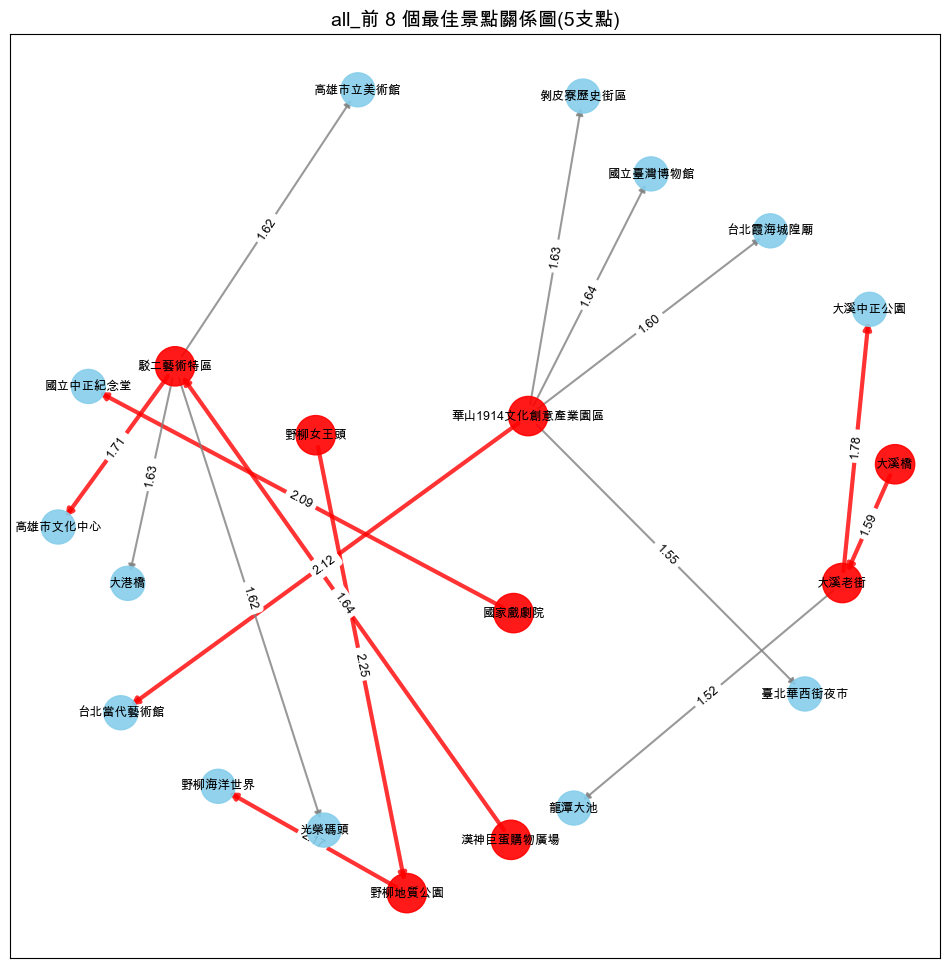

In [71]:
##### 畫圖
top_spots=8
top_n=5

top_rule = output_all_rule[
        (output_all_rule["支持度(Support)"] > 0.05) & 
        (output_all_rule["提升度(Lift)"] > 1.5) &
        (output_all_rule["信賴度(Confidence)"] > 0.5)
    ].sort_values(by="信賴度(Confidence)", ascending=False)


# 設定 Matplotlib 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 用戶
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

def plot_top_spots_network(top_rule, top_spots=5, top_n=5, output_path="output_graph.png"):
    """
    繪製前 `top_spots` 個景點的最佳關聯圖，根據 `提升度(Lift)` 來顯示影響關係。
    
    參數:
    - top_rule: (DataFrame) 過濾後的規則關聯表
    - top_spots: (int) 選擇前幾個信賴度最高的景點作為中心點
    - top_n: (int) 每個景點最多顯示的關聯景點數
    """

    # 取信賴度(Confidence)最高的前 `top_spots` 個景點
    top_attractions = (
        top_rule.groupby("景點")["信賴度(Confidence)"].max()
        .nlargest(top_spots)
        .index.tolist()
    )

    # 建立 NetworkX 有向圖
    G = nx.DiGraph()
    edge_labels = {}  # 存放提升度 (Lift) 值
    edge_weights = {}  # 存放邊的顏色與粗細
    max_lift_edges = []  # 記錄每個景點最高的提升度邊
    node_styles = {}  # 存放節點的顏色和大小

    for attraction in top_attractions:
        # 過濾與當前景點相關的規則
        related_rules = top_rule[
            (top_rule['景點'] == attraction)
        ].nlargest(top_n, '提升度(Lift)')  # 取提升度最高的前 N 個關聯

        if related_rules.empty:
            print(f"❌ 找不到與 {attraction} 相關的景點")
            continue

        # 添加中心景點（紅色）
        node_styles[attraction] = {'size': 800, 'color': 'red'}
        G.add_node(attraction)

        # 記錄當前景點的最高提升度
        max_lift = related_rules['提升度(Lift)'].max()
        max_lift_row = related_rules[related_rules['提升度(Lift)'] == max_lift].iloc[0]
        max_lift_edge = (attraction, max_lift_row['關聯景點'])
        max_lift_edges.append(max_lift_edge)

        # 添加關聯景點
        for _, row in related_rules.iterrows():
            related_spot = row['關聯景點']

            # ✅ 檢查該關聯景點是否也是中心點，若是則保持紅色
            if related_spot in top_attractions:
                node_styles[related_spot] = {'size': 800, 'color': 'red'}
            else:
                node_styles[related_spot] = {'size': 600, 'color': 'skyblue'}  # 非中心點才設為藍色
            
            G.add_node(related_spot)
            G.add_edge(attraction, related_spot, weight=row['提升度(Lift)'])

            # 記錄提升度
            edge_labels[(attraction, related_spot)] = f"{row['提升度(Lift)']:.2f}"
            edge_weights[(attraction, related_spot)] = row['提升度(Lift)']

    # 如果沒有任何關聯景點，則不畫圖
    if not G.nodes:
        print("⚠ 沒有可視化的資料")
        return

    # 取得節點大小和顏色
    node_sizes = [node_styles[node]['size'] for node in G.nodes()]
    node_colors = [node_styles[node]['color'] for node in G.nodes()]

    # 佈局
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=1.5, seed=123)  # 使節點分佈均勻

    # 畫節點
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

    # 畫邊（所有線條預設為灰色）
    for edge, lift in edge_weights.items():
        color = 'red' if edge in max_lift_edges else 'gray'  # 每個景點的最高提升度邊設為紅色
        width = 3 if edge in max_lift_edges else 1.5  # 最高提升度的線條較粗
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width, edge_color=color, alpha=0.8, arrows=True)

    # 加入節點標籤（景點名稱）
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='Arial Unicode MS')

    # 加入邊標籤（提升度 Lift 值）
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_family='Arial Unicode MS')

    plt.title(f"{language}_前 {top_spots} 個最佳景點關係圖({top_n}支點)", fontsize=14)
    
    # 儲存圖像為檔案
    plt.savefig(output_path, format="PNG")
    print(f"圖像已儲存為 {output_path}")

    plt.show()


# 🎯 執行函式，繪製前 10 個景點的最佳關聯圖
plot_top_spots_network(top_rule, top_spots, top_n, output_path=f"output/{language}_前 {top_spots} 個最佳景點關係圖({top_n}支點).png")


In [20]:
# top_rule.head(10)

2.三個指標TOP 5 景點的前3關係景點

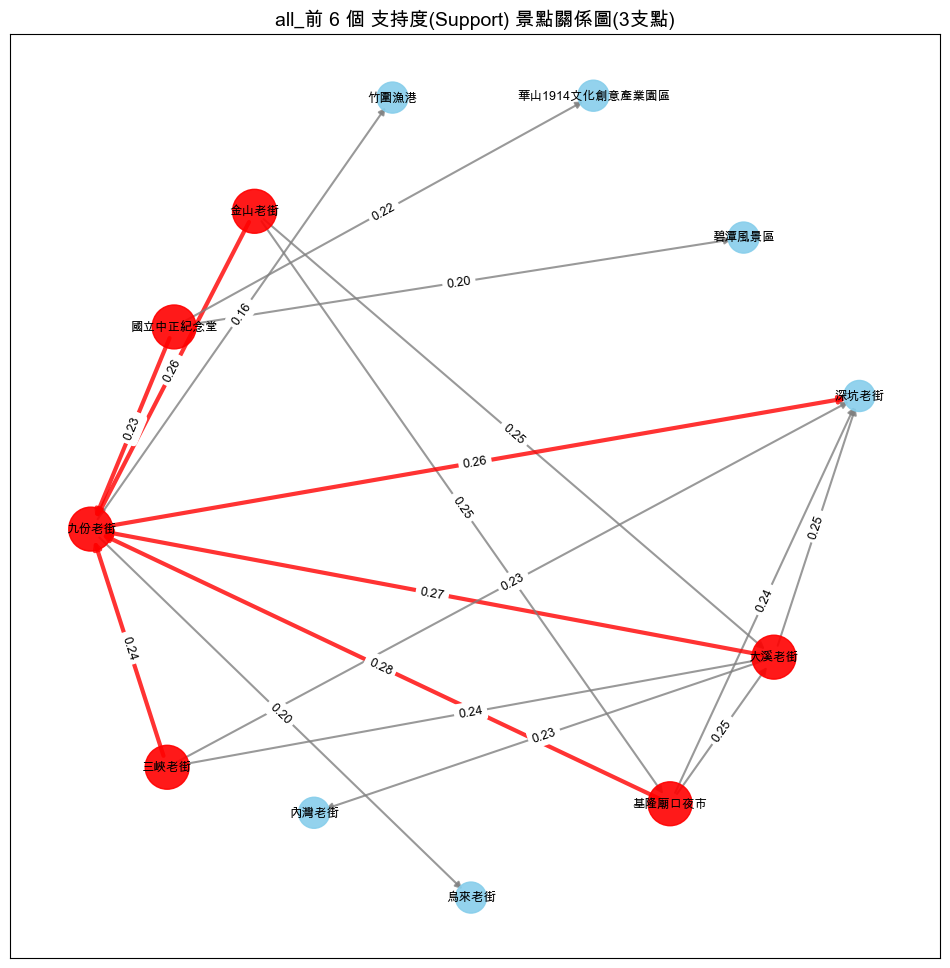

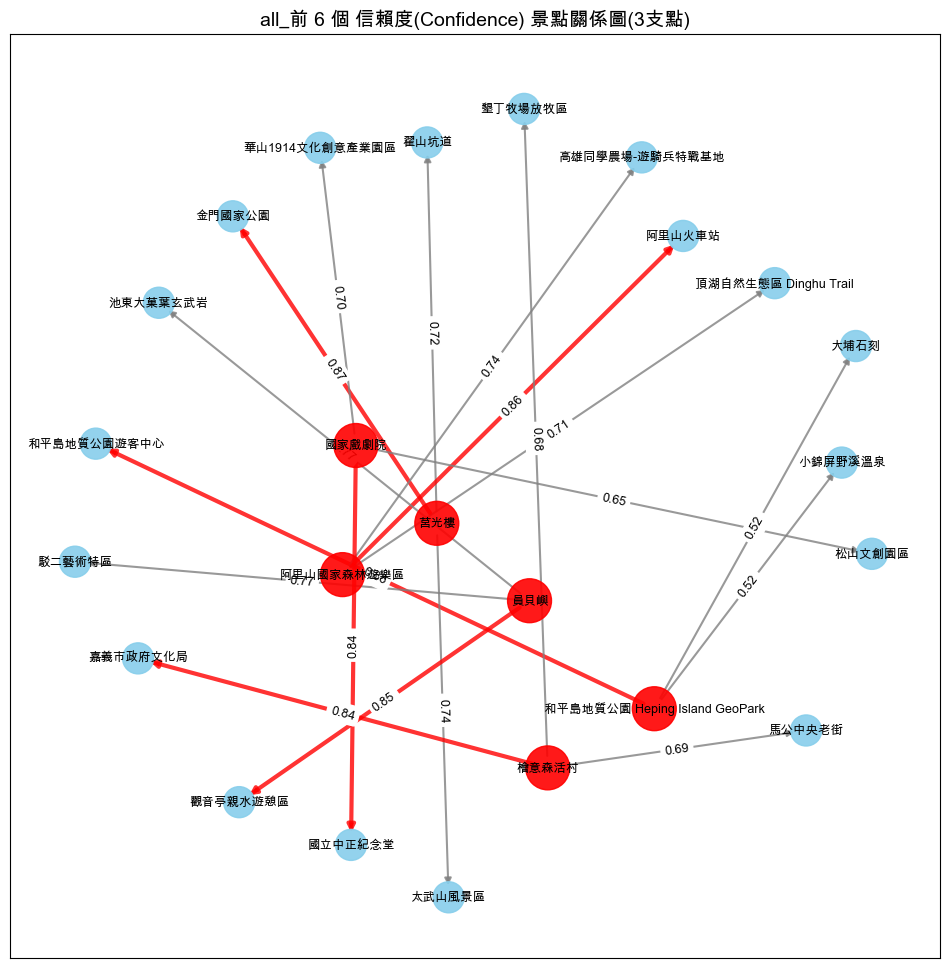

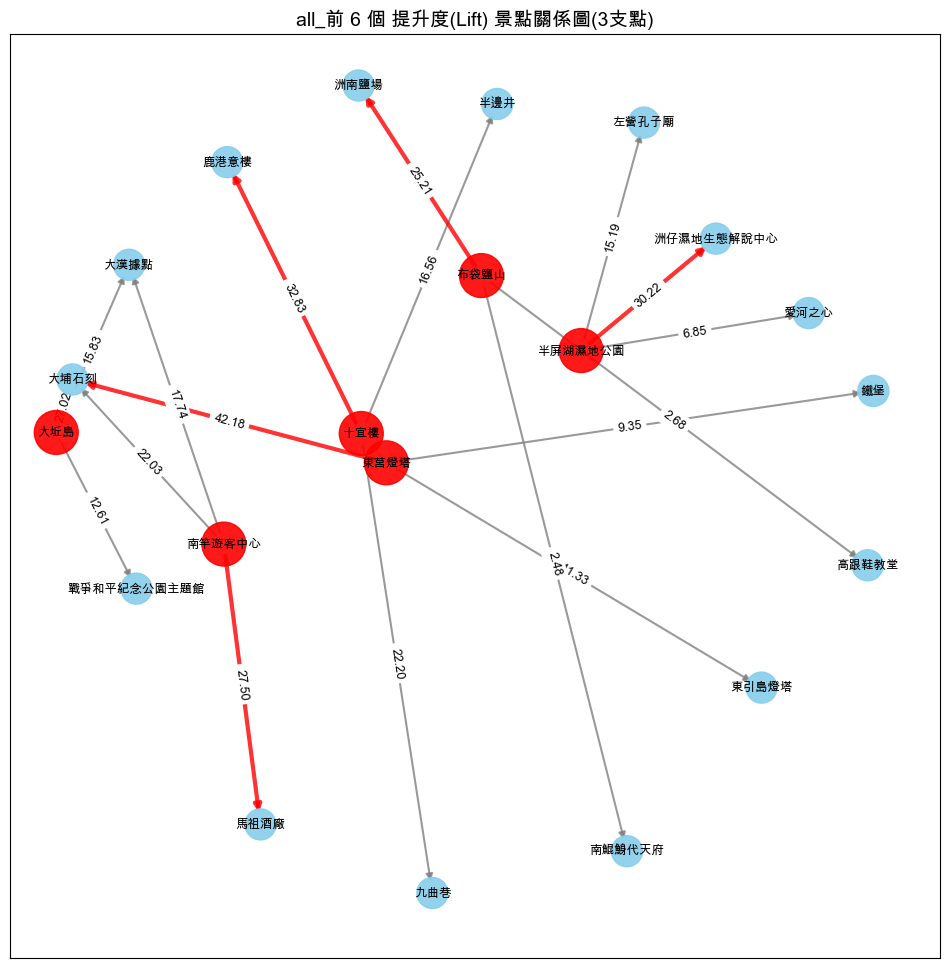

In [70]:
##### 三個指標TOP 5 景點的前3關係景點
top_spots = 6
top_n = 3

# 設定 Matplotlib 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 用戶
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


def plot_method_network(output_all_rule, method="提升度(Lift)", top_spots=5, top_n=5, output_path="output_graph.png"):
    """
    繪製不同方法的關聯圖，例如 支持度(Support)、信賴度(Confidence)、提升度(Lift)、最佳化。

    參數:
    - output_all_rule: (DataFrame) 原始的規則關聯表
    - method: (str) 選擇的評估方法 ["支持度(Support)", "信賴度(Confidence)", "提升度(Lift)", "最佳化"]
    - top_spots: (int) 選擇前幾個最重要的景點作為中心點
    - top_n: (int) 每個景點最多顯示的關聯景點數
    """

    methods = ["支持度(Support)", "信賴度(Confidence)", "提升度(Lift)"]

    if method not in methods:
        raise ValueError(f"❌ 無效的評估方法: {method}, 只能選擇 {methods}")

    # 根據所選方法篩選數據
    top_rule = output_all_rule.sort_values(by=method, ascending=False)


    # 取 `top_spots` 個最高權重的景點
    top_attractions = (
        top_rule.groupby("景點")[method].max()
        .nlargest(top_spots)
        .index.tolist()
    )

    # 建立 NetworkX 有向圖
    G = nx.DiGraph()
    edge_labels = {}
    edge_weights = {}
    max_method_edges = []
    node_styles = {}

    for attraction in top_attractions:
        # 過濾與當前景點相關的規則
        related_rules = top_rule[
            (top_rule['景點'] == attraction)
        ].nlargest(top_n, method)

        if related_rules.empty:
            print(f"❌ 找不到與 {attraction} 相關的景點")
            continue

        # 添加中心景點（紅色）
        node_styles[attraction] = {'size': 1000, 'color': 'red'}
        G.add_node(attraction)

        # 記錄當前景點的最高值
        max_method_value = related_rules[method].max()
        max_method_row = related_rules[related_rules[method] == max_method_value].iloc[0]
        max_method_edge = (attraction, max_method_row['關聯景點'])
        max_method_edges.append(max_method_edge)

        # 添加關聯景點
        for _, row in related_rules.iterrows():
            related_spot = row['關聯景點']

            # ✅ 若該景點也是中心點，則保持紅色
            if related_spot in top_attractions:
                node_styles[related_spot] = {'size': 1000, 'color': 'red'}
            else:
                node_styles[related_spot] = {'size': 500, 'color': 'skyblue'}  # 非中心點為藍色
            
            G.add_node(related_spot)
            G.add_edge(attraction, related_spot, weight=row[method])

            # 記錄方法值
            edge_labels[(attraction, related_spot)] = f"{row[method]:.2f}"
            edge_weights[(attraction, related_spot)] = row[method]

    # 如果沒有任何關聯景點，則不畫圖
    if not G.nodes:
        print("⚠ 沒有可視化的資料")
        return

    # 取得節點大小和顏色
    node_sizes = [node_styles[node]['size'] for node in G.nodes()]
    node_colors = [node_styles[node]['color'] for node in G.nodes()]

    # 佈局
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=1.5, seed=123)

    # 畫節點
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

    # 畫邊（所有線條預設為灰色）
    for edge, value in edge_weights.items():
        color = 'red' if edge in max_method_edges else 'gray'  # 最高值的邊標紅色
        width = 3 if edge in max_method_edges else 1.5  # 最高值的線條較粗
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width, edge_color=color, alpha=0.8, arrows=True)

    # 加入節點標籤（景點名稱）
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='Arial Unicode MS')

    # 加入邊標籤（方法值）
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_family='Arial Unicode MS')

    plt.title(f"{language}_前 {top_spots} 個 {method} 景點關係圖({top_n}支點)", fontsize=14)
    
    # # 儲存圖像為檔案
    # plt.savefig(output_path, format="PNG")
    # print(f"圖像已儲存為 {output_path}")

    plt.show()


# 🎯 測試：繪製不同方法的圖
plot_method_network(output_all_rule, method="支持度(Support)", top_spots=top_spots, top_n=top_n, output_path=f"output/{language}_前 {top_spots} 個 支持度(Support)景點關係圖({top_n}支點).png")
plot_method_network(output_all_rule, method="信賴度(Confidence)", top_spots=top_spots, top_n=top_n, output_path=f"output/{language}_前 {top_spots} 個 信賴度(Confidence)景點關係圖({top_n}支點).png")
plot_method_network(output_all_rule, method="提升度(Lift)", top_spots=top_spots, top_n=top_n, output_path=f"output/{language}_前 {top_spots} 個 提升度(Lift)景點關係圖({top_n}支點).png")


### 功能
1.輸入 xxx 給最佳下一個景點

圖像已儲存為 output/景點關聯圖_all.png


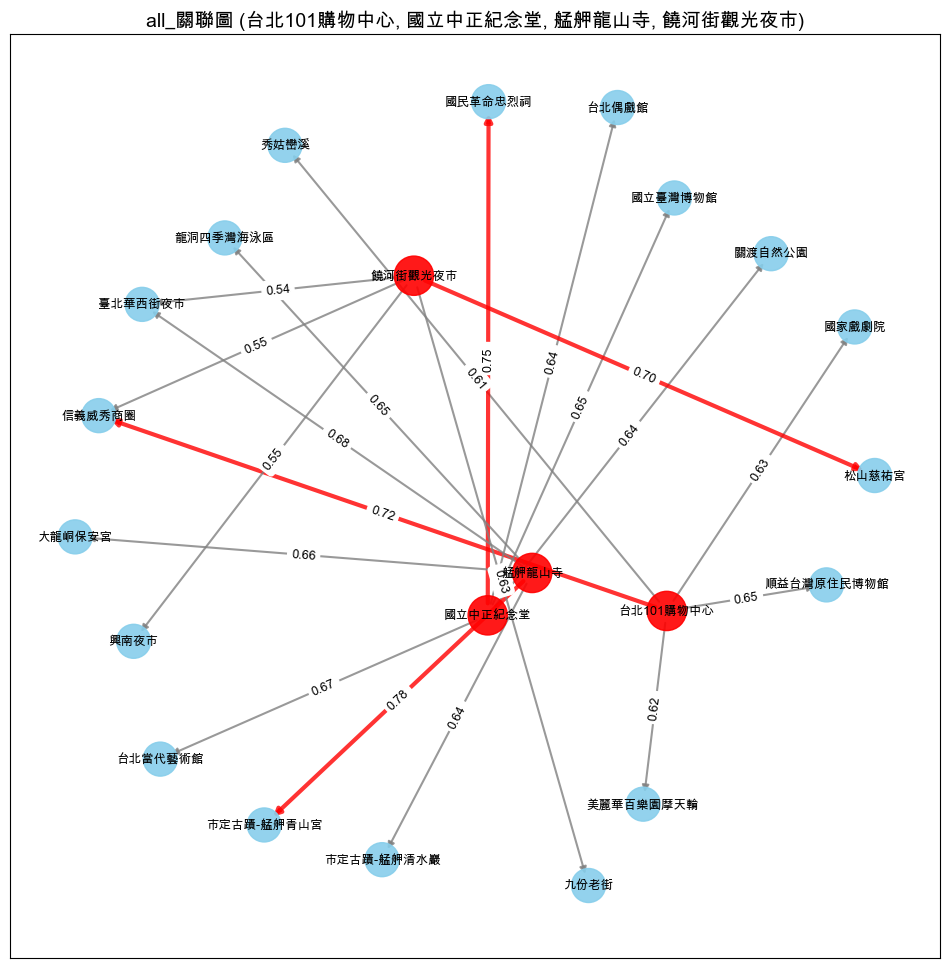

圖像已儲存為 output/景點關聯圖_ko.png


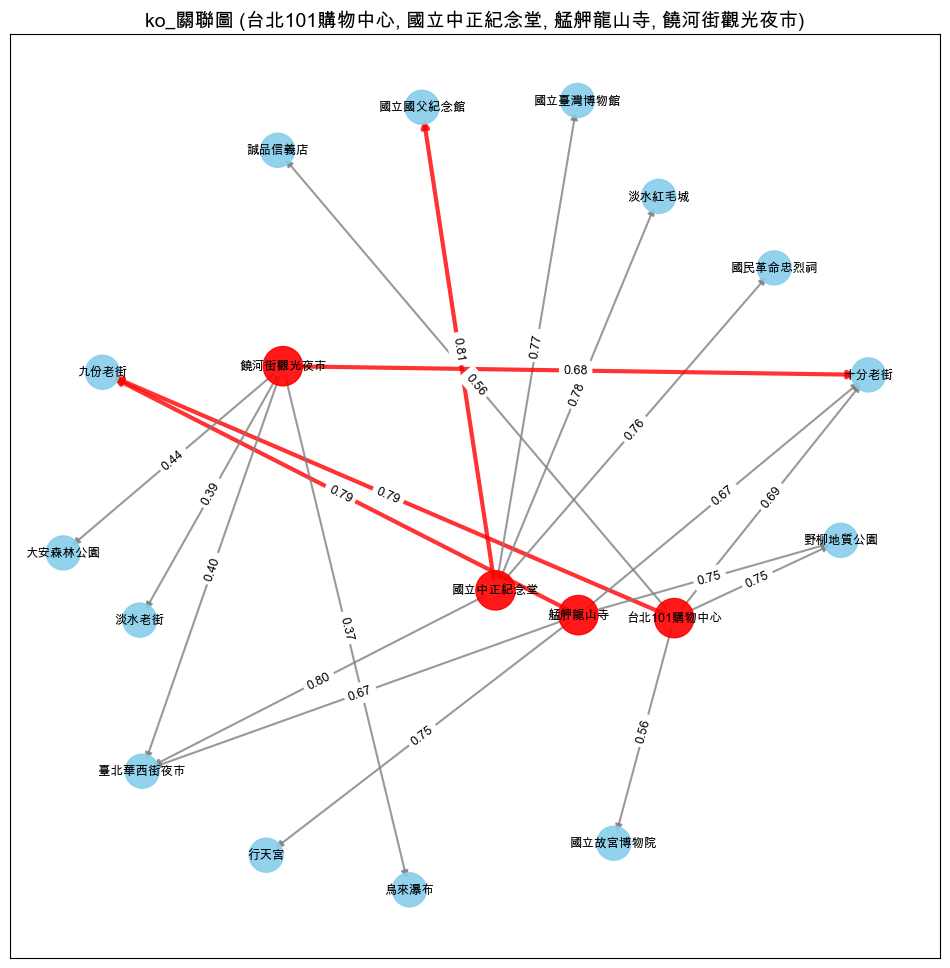

圖像已儲存為 output/景點關聯圖_en.png


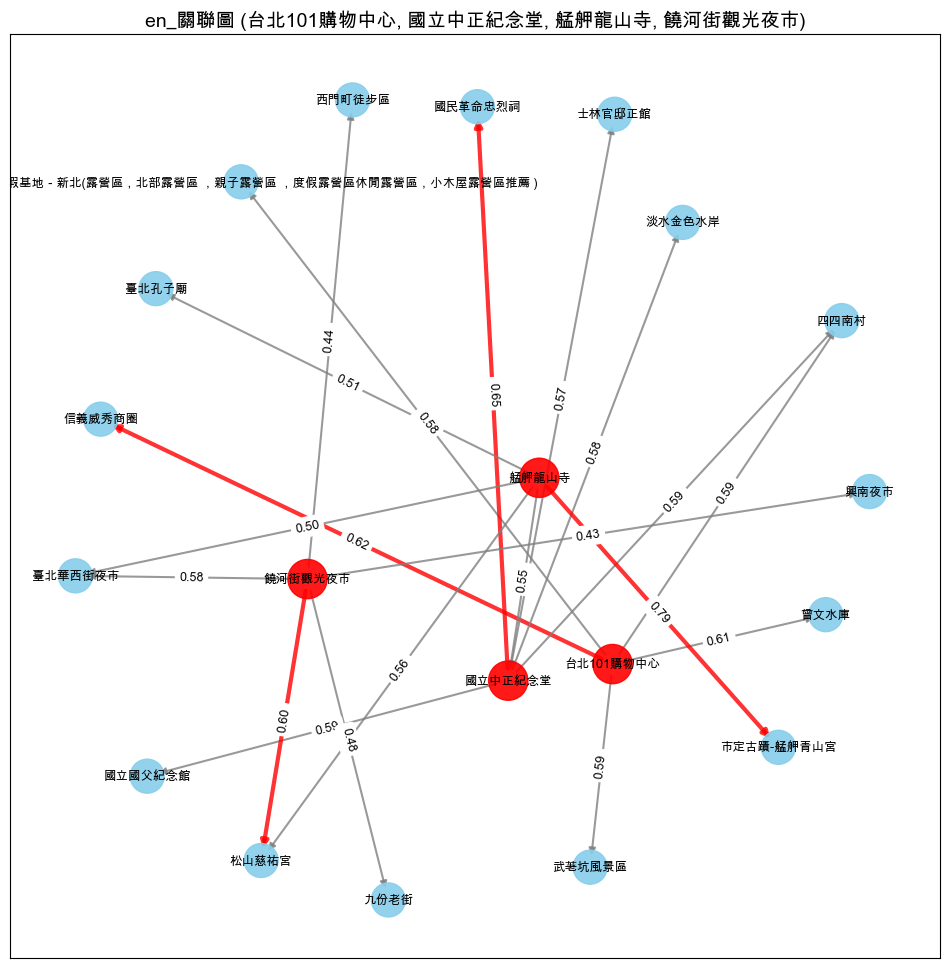

圖像已儲存為 output/景點關聯圖_ja.png


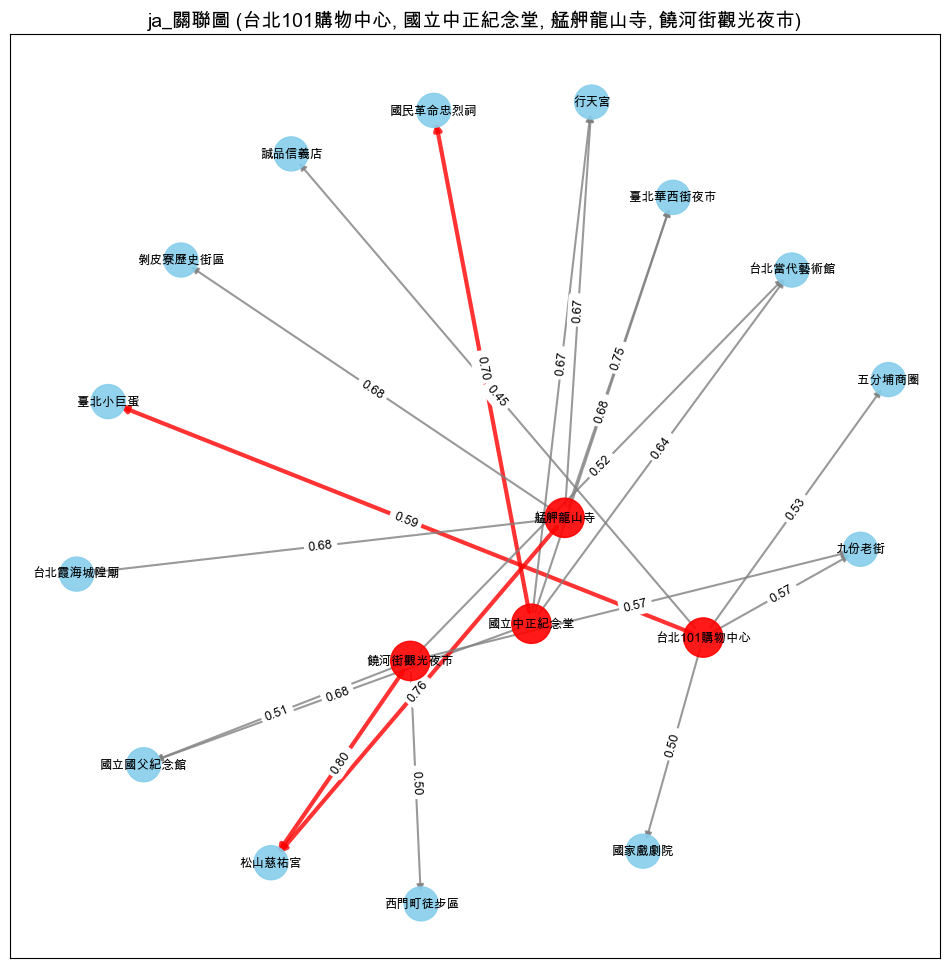

圖像已儲存為 output/景點關聯圖_zh-Hant.png


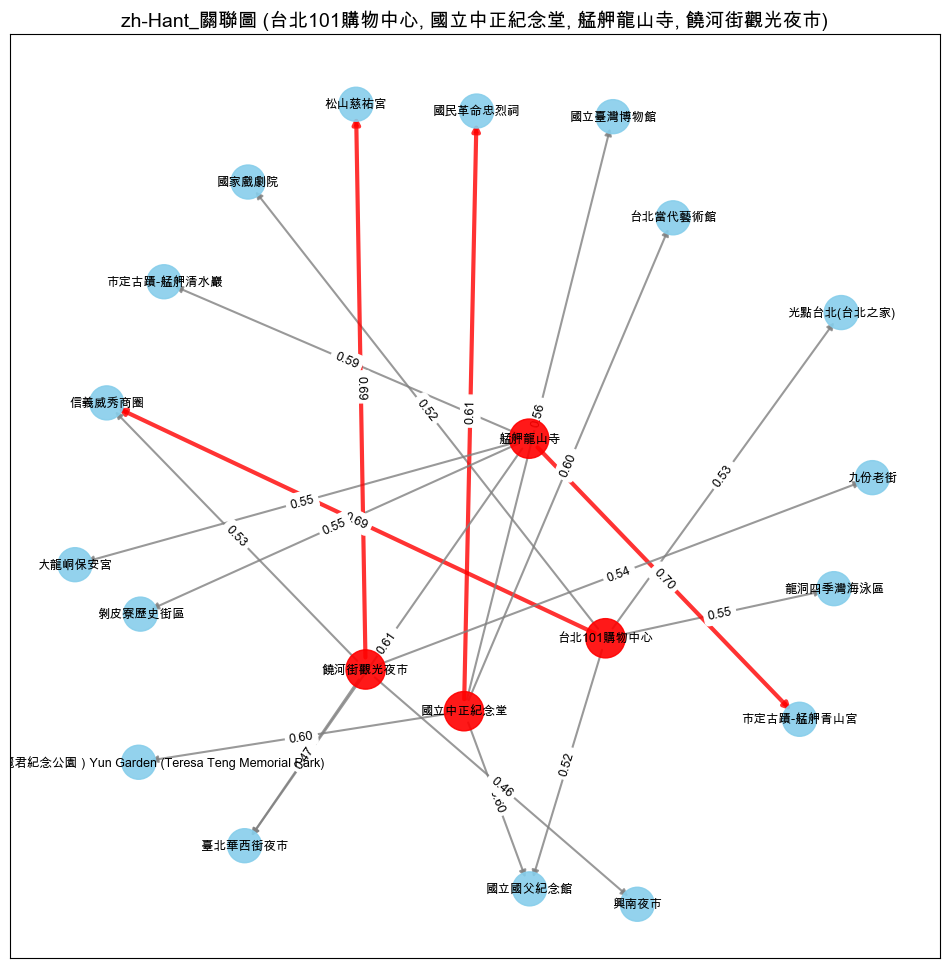

,檔案名稱,景點,關聯景點,支持度(Support),信賴度(Confidence),提升度(Lift),景點_類別,關聯景點_類別,景點_經緯度,關聯景點_經緯度,距離(km),景點_id,關聯景點_id,語系
0,all,台北101購物中心,信義威秀商圈,0.028186,0.718750,1.952211,城市景觀,購物與美食,"(25.034127, 121.5614409)","(25.0352187, 121.5646566)",0.346333,0x3442abb6da80a7ad:0xacc4d11dc963103c,0x3442abb0bca8f597:0xf776e49ddb067b30,all
1,all,台北101購物中心,順益台灣原住民博物館,0.004902,0.651163,1.768636,城市景觀,人文歷史,"(25.034127, 121.5614409)","(25.1009833, 121.5494039)",7.504850,0x3442abb6da80a7ad:0xacc4d11dc963103c,0x3442ac3bab42f751:0x839262f97eb2d2b8,all
2,all,台北101購物中心,國家戲劇院,0.040091,0.627397,1.704086,城市景觀,城市景觀,"(25.034127, 121.5614409)","(25.035305, 121.5181598)",4.369951,0x3442abb6da80a7ad:0xacc4d11dc963103c,0x3442a99e1c9b0373:0x99b7a63a01e8db42,all
3,all,台北101購物中心,美麗華百樂園摩天輪,0.109944,0.624254,1.695550,城市景觀,購物與美食,"(25.034127, 121.5614409)","(25.0829319, 121.5577484)",5.419125,0x3442abb6da80a7ad:0xacc4d11dc963103c,0x3442ac12f6cf7d73:0x4d733f290725ce21,all
4,all,台北101購物中心,秀姑巒溪,0.002976,0.607143,1.649073,城市景觀,自然景觀與戶外,"(25.034127, 121.5614409)","(23.3249405, 121.012243)",197.363550,0x3442abb6da80a7ad:0xacc4d11dc963103c,0x346f6a6d5f66b3cd:0xadc5174cf9ed1c5b,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,zh-Hant,饒河街觀光夜市,松山慈祐宮,0.023408,0.685092,2.833952,購物與美食,宗教聖地,"(25.0508902, 121.5749088)","(25.0512182, 121.57769)",0.282988,0x3442ab9c0db4a583:0x3da21183815df6f6,0x3442ab9c6d479ecb:0xe9dd0be65263781,zh-Hant
96,zh-Hant,饒河街觀光夜市,九份老街,0.129571,0.535985,1.377042,購物與美食,人文歷史,"(25.0508902, 121.5749088)","(25.1098743, 121.8403171)",27.561220,0x3442ab9c0db4a583:0x3da21183815df6f6,0x345d4517fafb9471:0x5f15825aa6a4a7d2,zh-Hant
97,zh-Hant,饒河街觀光夜市,信義威秀商圈,0.013278,0.527273,2.181117,購物與美食,購物與美食,"(25.0508902, 121.5749088)","(25.0352187, 121.5646566)",2.020903,0x3442ab9c0db4a583:0x3da21183815df6f6,0x3442abb0bca8f597:0xf776e49ddb067b30,zh-Hant
98,zh-Hant,饒河街觀光夜市,臺北華西街夜市,0.029073,0.468635,1.938554,購物與美食,購物與美食,"(25.0508902, 121.5749088)","(25.0386036, 121.4958623)",8.092137,0x3442ab9c0db4a583:0x3da21183815df6f6,0x3442a9a940c8f96b:0x6aee182d28c2fb39,zh-Hant


In [ ]:
##### 輸入景點->畫出各語系關係圖及datafrmae

# merged_rules.csv 包含所有語系
output_all_rule = pd.read_csv("output/merged_rules.csv", encoding="utf-8")

# 使用者輸入的景點名稱
input_locations = ["台北101購物中心", "國立中正紀念堂", "艋舺龍山寺", "饒河街觀光夜市"]

# 設定 Matplotlib 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 用戶
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

def plot_and_output_related_spots(input_locations, output_all_rule, language, top_n=5, output_path="output_graph.png"):
    """
    根據自訂的景點列表，繪製關聯圖並輸出相關景點的資料，保留所有原欄位。
    
    參數:
    - input_locations: (list) 使用者輸入的景點列表
    - output_all_rule: (DataFrame) 規則關聯資料表
    - language: (str) 需要處理的語系
    - top_n: (int) 每個景點最多顯示的關聯景點數
    - output_path: (str) 圖像輸出路徑
    """
    
    # 過濾出與輸入景點相關的規則，並選擇對應語系的資料
    related_rules = output_all_rule[output_all_rule['檔案名稱'] == language]
    related_rules = related_rules[related_rules['景點'].isin(input_locations)]

    if related_rules.empty:
        print(f"❌ 找不到與輸入景點 {input_locations} 相關的資料 ({language})")
        return pd.DataFrame()  # 如果沒有資料，返回空 DataFrame

    # 建立 NetworkX 有向圖
    G = nx.DiGraph()
    edge_labels = {}  # 存放信賴度 (Confidence) 值
    edge_weights = {}  # 存放邊的顏色與粗細
    max_confidence_edges = []  # 記錄每個景點最高的信賴度邊
    node_styles = {}  # 存放節點的顏色和大小
    all_related_spots = []  # 用於存放所有相關景點的資料

    for attraction in input_locations:
        # 過濾與當前景點相關的規則
        related_spots = related_rules[related_rules['景點'] == attraction]
        
        if related_spots.empty:
            print(f"❌ 找不到與 {attraction} 相關的景點")
            continue
        
        # 按信賴度排序並選擇前 `top_n` 個關聯景點
        related_spots = related_spots.nlargest(top_n, '信賴度(Confidence)')

        # 添加中心景點（紅色）
        node_styles[attraction] = {'size': 800, 'color': 'red'}
        G.add_node(attraction)

        # 記錄當前景點的最高信賴度
        max_confidence = related_spots['信賴度(Confidence)'].max()
        max_confidence_row = related_spots[related_spots['信賴度(Confidence)'] == max_confidence].iloc[0]
        max_confidence_edge = (attraction, max_confidence_row['關聯景點'])
        max_confidence_edges.append(max_confidence_edge)

        # 添加關聯景點並記錄相關資料
        for _, row in related_spots.iterrows():
            related_spot = row['關聯景點']

            # ✅ 檢查該關聯景點是否也是中心點，若是則保持紅色
            if related_spot in input_locations:
                node_styles[related_spot] = {'size': 800, 'color': 'red'}
            else:
                node_styles[related_spot] = {'size': 600, 'color': 'skyblue'}  # 非中心點設為藍色
            
            G.add_node(related_spot)
            G.add_edge(attraction, related_spot, weight=row['信賴度(Confidence)'])

            # 記錄信賴度
            edge_labels[(attraction, related_spot)] = f"{row['信賴度(Confidence)']:.2f}"
            edge_weights[(attraction, related_spot)] = row['信賴度(Confidence)']

            # 記錄所有相關景點的資料
            all_related_spots.append(row)  # 這樣會保留每一行所有原始資料

    # 如果沒有任何關聯景點，則不畫圖
    if not G.nodes:
        print("⚠ 沒有可視化的資料")
        return pd.DataFrame()  # 返回空 DataFrame

    # 取得節點大小和顏色
    node_sizes = [node_styles[node]['size'] for node in G.nodes()]
    node_colors = [node_styles[node]['color'] for node in G.nodes()]

    # 佈局
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=1.5, seed=123)  # 使節點分佈均勻

    # 畫節點
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

    # 畫邊（所有線條預設為灰色）
    for edge, confidence in edge_weights.items():
        color = 'red' if edge in max_confidence_edges else 'gray'  # 每個景點的最高信賴度邊設為紅色
        width = 3 if edge in max_confidence_edges else 1.5  # 最高信賴度的線條較粗
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width, edge_color=color, alpha=0.8, arrows=True)

    # 加入節點標籤（景點名稱）
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='Arial Unicode MS')

    # 加入邊標籤（信賴度 Confidence 值）
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_family='Arial Unicode MS')

    plt.title(f"{language}_關聯圖 ({', '.join(input_locations)})", fontsize=14)

    # 儲存圖像為檔案
    plt.savefig(output_path, format="PNG")
    print(f"圖像已儲存為 {output_path}")

    # 顯示圖像
    plt.show()

    # 將所有關聯景點資料轉換為 DataFrame 並回傳
    related_spots_df = pd.DataFrame(all_related_spots)

    # 保留與原資料集一致的所有欄位
    related_spots_df['語系'] = language  # 新增語系欄位
    return related_spots_df


# 定義語系列表
languages = ['all', 'ko', 'en', 'ja', 'zh-Hant']
all_related_spots = []  # 用來匯總所有語系的結果

# 執行函式，繪製各語系的關聯圖並匯總資料
for language in languages:
    related_spots_df = plot_and_output_related_spots(input_locations, output_all_rule, language, top_n=5, output_path=f"output/景點關聯圖_{language}.png")
    
    if not related_spots_df.empty:
        all_related_spots.append(related_spots_df)

# 將所有語系的結果合併成一個 DataFrame
final_related_spots_df = pd.concat(all_related_spots, ignore_index=True)

# 顯示最終的結果
final_related_spots_df


In [111]:
##### 計算838景點關聯程度高不高，是否達成旅客旅遊景點的參考依據?

# 載入資料
output_all_rule = pd.read_csv("output/merged_rules.csv", encoding="utf-8")

# 篩選符合條件的資料
filtered_rules = output_all_rule[(output_all_rule['提升度(Lift)'] >= 1) & 
                                  (output_all_rule['信賴度(Confidence)'] >= 0.5)]

# 定義語系列表
languages = ['all', 'ko', 'en', 'ja', 'zh-Hant']

# 用來儲存結果
result = {}

# 總景點數量
total_sights = 838

for language in languages:
    # 過濾出當前語系的資料
    language_data = filtered_rules[filtered_rules['檔案名稱'] == language]
    
    # 計算不重複的景點數量
    unique_sights_count = language_data['景點'].nunique()
    
    # 計算比例
    proportion = unique_sights_count / total_sights * 100
    
    # 儲存結果
    result[language] = {'count': unique_sights_count, 'proportion': proportion}

# 顯示結果
result


{'all': {'count': 541, 'proportion': 64.55847255369929},
 'ko': {'count': 47, 'proportion': 5.608591885441527},
 'en': {'count': 102, 'proportion': 12.17183770883055},
 'ja': {'count': 64, 'proportion': 7.637231503579953},
 'zh-Hant': {'count': 317, 'proportion': 37.828162291169456}}

### FP-Growth：關聯規則（比 Apriori 快）

In [ ]:
# import pandas as pd
import pyfpgrowth  # 請先執行：pip install pyfpgrowth


# # 將相同 user_id 的 gmap_location 合併成交易資料
# transactions = data.groupby("user_id")["gmap_location"].apply(list).tolist()
total = len(transactions)
# print("交易資料：")
# print(transactions)

# 參數設定
min_support = 0.4      # 最小支持度比例（例如3%）
min_confidence = 0.7    # 最小信賴度
min_lift = 2            # 最小提升度
max_length = 2          # 只考慮包含2個景點的規則

# FP-Growth 需要的是最小支持度數量 (count)
# min_support_count = max(1, int(total * min_support))
min_support_count = 2



In [ ]:
# 使用 FP-Growth 演算法挖掘頻繁項集
# frequent_patterns 為字典，key 是 frozenset（項集），value 是出現次數
frequent_patterns = pyfpgrowth.find_frequent_patterns(transactions, min_support_count)

# # 使用 FP-Growth 生成關聯規則
# # generate_association_rules 回傳一個字典：
# # key 為 antecedent（前件，frozenset），value 為 (consequent, confidence)
# rules = pyfpgrowth.generate_association_rules(frequent_patterns, min_confidence)

# association_results = []

In [ ]:
# # 計算支持度（作為比例）方便後續計算提升度
# # frequent_patterns 中存放的是每個項集的出現次數
# def get_support(itemset):
#     return frequent_patterns.get(frozenset(itemset), 0) / total

# # 遍歷生成的關聯規則
# for antecedent, (consequent, confidence) in rules.items():
#     # 只考慮規則中總項數等於 max_length 的規則
#     if len(antecedent) + len(consequent) != max_length:
#         continue

#     # 計算完整規則的支持度
#     full_rule = list(antecedent) + list(consequent)
#     support_full = get_support(full_rule)
#     # 計算 consequent 的支持度
#     support_consequent = get_support(list(consequent))
#     # 提升度 = confidence / support(consequent)
#     lift = confidence / support_consequent if support_consequent > 0 else 0

#     if lift < min_lift:
#         continue

#     association_results.append((list(antecedent), list(consequent), support_full, confidence, lift))

# # 顯示結果
# print("\n關聯規則：")
# for rule in association_results:
#     antecedent, consequent, support, confidence, lift = rule
#     print("Rule: {} -> {}".format(antecedent, consequent))
#     print("Support: {:.4f}".format(support))
#     print("Confidence: {:.2f}".format(confidence))
#     print("Lift: {:.2f}".format(lift))
#     print("=====================================")